## import basic libary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
import os.path

In [2]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

from sklearn import metrics 
from sklearn import model_selection
sklearn.__version__

'0.18.1'

In [3]:
from subfunctions.NMR_ML import merge_excel
from subfunctions.T2dist import t2_dist_process

## preprocessing

In [4]:
def maybe_t2_dist_process(input_filename,sheetname='t2dist-nmr',output_filename='nmr_t2_dist.csv',force=False):
    '''
    process t2 distribution to calculate mean and std of t2 if needed
    '''
    # check input file existence
    if  not os.path.isfile(input_filename):
        print('ValueError: %s input file is not there, please double check' %input_filename)
        return -1
    # check output file existence
    if os.path.isfile(output_filename) and not force:
        print('file \'%s\' already present - Skipping processing '%output_filename)
    else:
        print('processing to file \'%s\' ...'%output_filename)
        # read the file
        df_t2_dist = pd.read_excel(filename,sheetname=sheetname)
        # process t2 distribution
        df_t2_dist_stats = t2_dist_process(df_t2_dist)
        df_t2_dist_stats.to_csv(output_filename,index=False)
        print('finished')
        
#------------------------------------------------------------------------        
# all parameters
filename = 'KC151-2-to_excel.xlsx'
sheetname='t2dist-nmr'
output_filename_logs_t2 = 'nmr_t2_dist.csv'
maybe_t2_dist_process(input_filename=filename,sheetname=sheetname,output_filename=output_filename_logs_t2,force=False)
    

file 'nmr_t2_dist.csv' already present - Skipping processing 


In [5]:
def maybe_merge_excel(input_filename,sheetname_list,output_filename='merge_log.csv',depth_name='DEPTH(m)',force=False):
    '''
    process to merge different logs data
    '''
    if  not os.path.isfile(input_filename):
        print('ValueError: %s input file is not there, please double check' %input_filename)
        return -1
    if os.path.isfile(output_filename) and not force:
        print('file \'%s\' already present - Skipping merge '%output_filename)
    else:
        print('merging log data to file \'%s\' ...'%output_filename)
        merge_excel(input_filename,sheetname_list,output_filename=output_filename,depth_name='DEPTH(m)')
        
#------------------------------------------------------
filename = 'KC151-2-to_excel.xlsx'
sheetname_list=['dr-rab','den-adn','por-adn','nmr']
depth_name = 'DEPTH(m)'
output_filename_logs='merge_log.csv'
maybe_merge_excel(filename,sheetname_list,output_filename_logs,depth_name,force=False)

file 'merge_log.csv' already present - Skipping merge 


## depth matching for t2 distribution and other logs

In [6]:
def maybe_depth_matching(file_log,file_log_t2,output_filename,min_depth=-1,max_depth=99999,force=False):
    if  not os.path.isfile(output_filename) or force:
        df_logs_t2 = pd.read_csv(file_log_t2)
        df_logs = pd.read_csv(file_log)
        # check depth for x and y 
        min_depth = max(df_logs_t2['DEPTH(m)'][0],df_logs['DEPTH(m)'][0],min_depth)
        max_depth = min(df_logs_t2['DEPTH(m)'][len(df_logs_t2)-1], df_logs['DEPTH(m)'][len(df_logs)-1],max_depth)

        df_logs_t2 =df_logs_t2[ (df_logs_t2['DEPTH(m)']<= max_depth) & (df_logs_t2['DEPTH(m)'] >= min_depth) ]
        df_logs =df_logs[ (df_logs['DEPTH(m)']<= max_depth) & (df_logs['DEPTH(m)'] >= min_depth) ]

        print(min_depth,max_depth)
        print(len(df_logs_t2),len(df_logs))

        writer = pd.ExcelWriter('KC151-2-data.xlsx', engine='openpyxl')
        df_logs_t2.to_excel(writer,'logs_t2',index=False)
        df_logs.to_excel(writer,'logs',index=False)
        writer.save()
    else:
         print('file \'%s\' already present - Skipping depth matching '%filename)
            
#-----------------------------------------------------------
output_filename = 'KC151-2-data.xlsx' 
maybe_depth_matching(output_filename_logs,output_filename_logs_t2,output_filename,min_depth=120,force=True)    


120 425.3724
2004 2004


## start to machine learning

In [7]:
# standardlize the x data 
def get_standard_logs(df,do_plot=False,do_describe=False):
    '''
    standardization of input data
    df: dataframe type 
    '''
    df_standard = (df - df.mean())/df.std()
    if do_plot:
        figure = plt.figure()
        fig,axies = plt.subplots(1,2,figsize=(7,4),dpi=600)
        axies[0] = df['GR(gAPI)'].hist(ax=axies[0])
        axies[1] = df_standard['GR(gAPI)'].hist(ax=axies[1])
        axies[0].set_xlabel('origin GR')
        axies[1].set_xlabel('standard GR')
    if do_describe:
        print(df_standard.describe())
    return df_standard
   
def my_data_split(x,y,test_size=0.1,start_point=0.5):
    '''
    self-defined training-testing data splitting
    '''
    i_len = int(len(x)*(test_size))
    if start_point + test_size < 1:
        i0 = int(len(x)*start_point)
        print('i_test_size',i_len,i0)
        x_train= np.vstack( (x[:i0,:], x[i0+i_len:,:]) )
        x_test= x[i0:i0+i_len,:]
        y_train= np.append( y[:i0],y[i0+i_len:]  )
        y_test= y[i0:i0+i_len]
    return x_train,x_test,y_train,y_test

In [8]:
df_logs  = pd.read_excel('KC151-2-data.xlsx','logs')
df_logs_t2  = pd.read_excel('KC151-2-data.xlsx','logs_t2')
df_logs.head()

,DEPTH(m),RHOB(g_cm^3),DRHO,DRRT,PEF,IDRO,IDDR,IDPE,MRP_T2(%),BFV_T2(%),FFV_T2(%),T2LM_T2(ms),TNPH(%),GR(gAPI)
0,120.1152,2.0106,0.0941,0.0303,3.2276,2.0186,0.0896,3.0509,34.8235,34.8235,0.0,3.0954,52.6965,70.7477
1,120.2676,1.9995,0.1040,0.0253,3.2435,2.0121,0.1025,3.0855,35.0284,35.0284,0.0,3.1099,52.5280,68.8660
2,120.4200,1.9708,0.0968,0.0263,3.2482,1.9857,0.1025,3.1723,35.0669,35.0669,0.0,3.1221,50.5053,70.0654
3,120.5724,1.9468,0.0912,0.0269,3.2836,1.9528,0.0882,3.1297,35.2049,35.2049,0.0,2.9670,47.9379,69.5962
4,120.7248,1.9103,0.0842,0.0301,3.3407,1.9194,0.0831,3.2141,35.8565,35.8565,0.0,2.9625,50.1841,71.4585


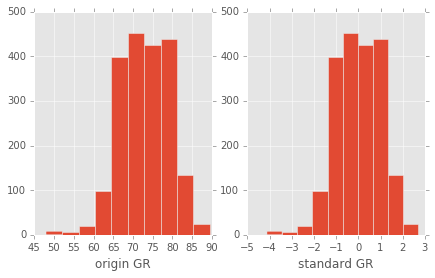

In [9]:
# standardization of x 
df_logs_stand = get_standard_logs(df_logs,True)

## create x matrix and y vector

In [10]:
def get_y_data(df,colname):
    y = df[colname]
    y_data = np.array([y]).T.ravel() ## should be in shape (n,) not (n,1)
    print('y shape',y_data.shape)
    return y_data

def get_x_data(df_standard,df,colnames):
    x_data =[]
    for col in colnames:
        x_data.append(df_standard[col])
    # adding index to col0
    x_data.insert(0,np.arange(0,len(x_data[0])).astype(int))   
    x_data.insert(1,df['DEPTH(m)'])  # insert depth to check the sort 
    x_data = np.array(x_data).T
    print('x shape',x_data.shape)
    return x_data

#-----------------------------------------------------
y_colname = 't2_mean_log10'
print('x variables: ',df_logs.columns.values)
x_colnames = ['DEPTH(m)','GR(gAPI)','RHOB(g_cm^3)','TNPH(%)']
y_data = get_y_data(df_logs_t2,y_colname)
x_data = get_x_data(df_logs_stand,df_logs,x_colnames)
#print(y_data.shape)

x variables:  ['DEPTH(m)' 'RHOB(g_cm^3)' 'DRHO' 'DRRT' 'PEF' 'IDRO' 'IDDR' 'IDPE'
 'MRP_T2(%)' 'BFV_T2(%)' 'FFV_T2(%)' 'T2LM_T2(ms)' 'TNPH(%)' 'GR(gAPI)']
y shape (2004,)
x shape (2004, 6)


## split into training and testing 

do random split
x_train shape: (1603, 4) 
x_test shape: (401, 4)


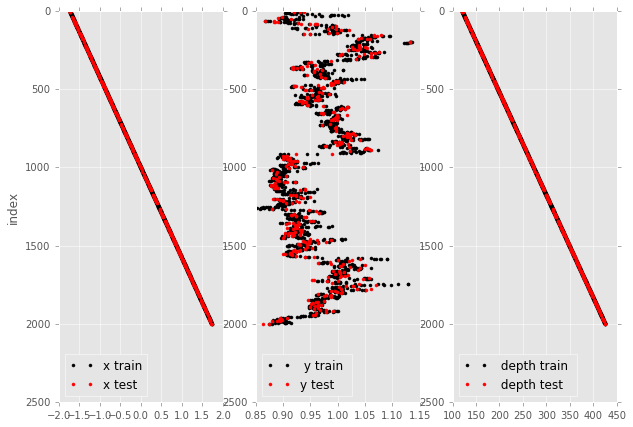

In [11]:
# split into training set and test set
def split_data(x_data,y_data,test_size = 0.2,do_random=True,start_point=0.5,do_plot=False):
    if do_random:
        print('do random split')
        x_all_train, x_all_test, y_train, y_test = model_selection.train_test_split(x_data, 
                                            y_data, test_size=test_size, random_state=2)
    else: # 
        print('do depth split')
        x_all_train, x_all_test, y_train, y_test  = my_data_split(x_data,
                                            y_data,test_size=test_size,start_point=start_point)
        
    # col 0 is the id of training and testing 
    id_train,id_test = x_all_train[:,0],x_all_test[:,0]  
    
    # col 1 is the depth of training and testing 
    depth_train,depth_test = x_all_train[:,1],x_all_test[:,1]  
    # the rest are training and testing data
    x_train,x_test = x_all_train[:,2:], x_all_test[:,2:] 
    mark_train = [0]*len(x_train)
    mark_test = [1]*len(x_test)
    
    id_vector = np.append(id_train,id_test)
    depth_vector = np.append(depth_train,depth_test)
    mark_vector = np.append(mark_train,mark_test)
    
    print('x_train shape:',x_train.shape,'\nx_test shape:',x_test.shape)
    
    if do_plot:
        figure = plt.figure()
        fig,axies = plt.subplots(1,3,figsize=(10,7),dpi=600)
        # the first x vs index
        legend01,=axies[0].plot(x_all_train[:,2],x_all_train[:,0],'k.',label='x train')
        legend02,=axies[0].plot(x_all_test[:,2],x_all_test[:,0],'r.',label='x test ')
        # y vs index
        legend11,=axies[1].plot(y_train,x_all_train[:,0],'k.',label=' y train ')
        legend12,=axies[1].plot(y_test,x_all_test[:,0],'r.',label='y test')
        # depth vs index
        legend21,=axies[2].plot(x_all_train[:,1],x_all_train[:,0],'k.',label=' depth train ')
        legend22,=axies[2].plot(x_all_test[:,1],x_all_test[:,0],'r.',label=' depth test')

        axies[0].invert_yaxis()
        axies[1].invert_yaxis()
        axies[2].invert_yaxis()
        
        axies[0].legend(handles=[legend01,legend02],loc=3)
        axies[1].legend(handles=[legend11,legend12],loc=3)
        axies[2].legend(handles=[legend21,legend22],loc=3)
        
        axies[0].set_ylabel('index')
    return x_train,x_test,y_train,y_test,id_vector,depth_vector,mark_vector

#--------------------------------------------------------
test_size = 0.2
x_train,x_test,y_train,y_test,id_vector,depth_vector,mark_vector = split_data(
                            x_data,y_data,test_size,do_random=True,start_point=0.6,do_plot=True)

using RandomForestRegressor
3.78746815326e-05 0.000208647397856


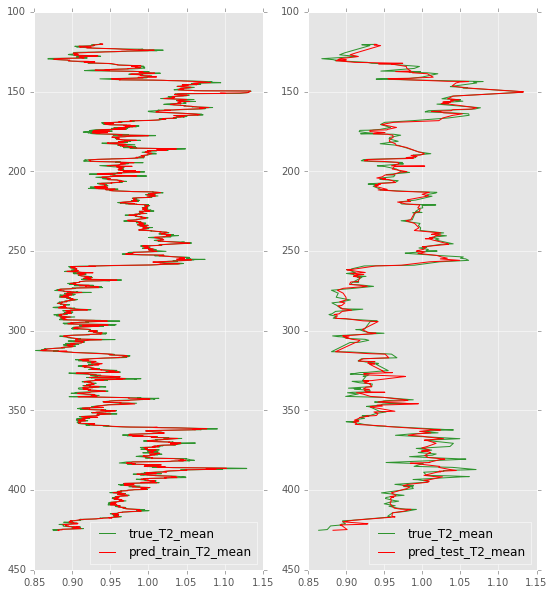

In [12]:
def get_model(x_train,y_train,model_parameters, model_type = 'RandomForestRegressor' ):
   
    '''
    model include  
    | 'RandomForestRegressor' | 'SVR'(support vector regressor) | 'GradientBoostingRegressor'
    '''
    print('using %s'%model_type)
    
    # selecting model 
    if model_type == 'RandomForestRegressor':
        #model = RandomForestRegressor(n_estimators=model_parameters[model_type]['n_estimators'],random_state=1)
        model = RandomForestRegressor(**model_parameters[model_type])
    elif model_type == 'SVR':
        model = svm.SVR()
    elif model_type =='GradientBoostingRegressor':
        model = GradientBoostingRegressor(**model_parameters[model_type])
        
    model.fit(x_train, y_train)    
    return model 

def plot_result(id_vector,depth_vector,mark_vector,y_train,y_test,yhat_train,yhat_test):
    
    # build up a new dataframe to store all the data

    data = {}
    data['id'] = id_vector
    data['DEPTH_true(m)'] = depth_vector
    data['marker'] = mark_vector
    
    data['true_t2_mean'] = np.append(y_train, y_test)
    data['pre_t2_mean'] = np.append(yhat_train,yhat_test)
    
    df_model = pd.DataFrame(data)
    # to go back to the original data
    df_model = df_model.sort_values(by='id')
    
    figure = plt.figure()
    fig,axies = plt.subplots(1,2,figsize=(9,10),dpi=600)
    i_train = df_model['marker'] ==0
    i_test =  df_model['marker'] ==1
    legend01,=axies[0].plot(df_model['true_t2_mean'][i_train],df_model['DEPTH_true(m)'][i_train],'g-',label='true_T2_mean',alpha=0.8)
    legend02,=axies[0].plot(df_model['pre_t2_mean'][i_train],df_model['DEPTH_true(m)'][i_train],'r-',label='pred_train_T2_mean')

    axies[0].legend(handles=[legend01,legend02],loc=4)

    legend11,=axies[1].plot(df_model['true_t2_mean'][i_test],df_model['DEPTH_true(m)'][i_test],'g-',label='true_T2_mean',alpha=0.8)
    legend12,=axies[1].plot(df_model['pre_t2_mean'][i_test],df_model['DEPTH_true(m)'][i_test],'r-',label='pred_test_T2_mean')
    #axies[3].invert_yaxis()
    axies[1].legend(handles=[legend11,legend12],loc=4)
   
    #axies[2].set_xlim([-2,4])
    axies[0].invert_yaxis()
    axies[1].invert_yaxis()
    #axies[0].set_ylim([0,])
    #return df_model 
    

#-----------------------------------------------------------
# setting model parameters
model_parameters = dict()
model_parameters['RandomForestRegressor'] = {'n_estimators':50,'random_state':1}
model_parameters['GradientBoostingRegressor'] = {'n_estimators':200,'learning_rate':0.4,'random_state':0,'loss':'ls'}
model_type = 'RandomForestRegressor'
# 
model = get_model(x_train,y_train,model_parameters,model_type)
# prediction 
yhat_test = model.predict(x_test) # prediction for test
yhat_train = model.predict(x_train) # prediction for train
# error 
MSE_train = metrics.mean_squared_error(y_train, yhat_train)
MSE_test  = metrics.mean_squared_error(y_test, yhat_test)
    
print(MSE_train,MSE_test)
plot_result(id_vector,depth_vector,mark_vector,y_train,y_test,yhat_train,yhat_test)

## test of different trees for random forest regressor

using RandomForestRegressor
using RandomForestRegressor
using RandomForestRegressor
using RandomForestRegressor
using RandomForestRegressor


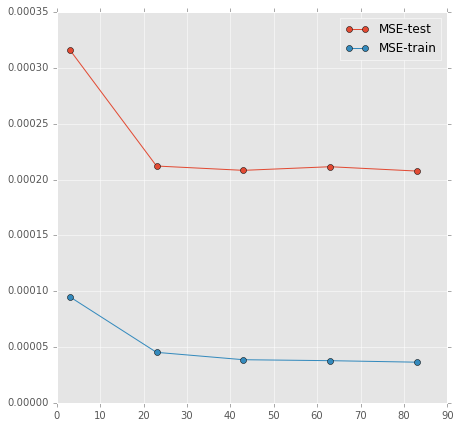

In [13]:
model_type = 'RandomForestRegressor'
# 
n_trees = np.arange(3,100,20)
MSE_train_all = []
MSE_test_all = []
for n_tree in n_trees:
    model_parameters['RandomForestRegressor']['n_estimators'] = n_tree
    model = get_model(x_train,y_train,model_parameters,model_type)
    # prediction 
    yhat_test = model.predict(x_test) # prediction for test
    yhat_train = model.predict(x_train) # prediction for train
    # error 
    MSE_train = metrics.mean_squared_error(y_train, yhat_train)
    MSE_test  = metrics.mean_squared_error(y_test, yhat_test)
    MSE_train_all.append(MSE_train)
    MSE_test_all.append(MSE_test)
    
figure = plt.figure()
fig,axies = plt.subplots(figsize=(7,7),dpi=600)
legend1,=axies.plot(n_trees,MSE_test_all,'o-',label='MSE-test')
legend2,=axies.plot(n_trees,MSE_train_all,'o-',label='MSE-train')
axies.legend(handles=[legend1,legend2],loc=1)

# currently not in used

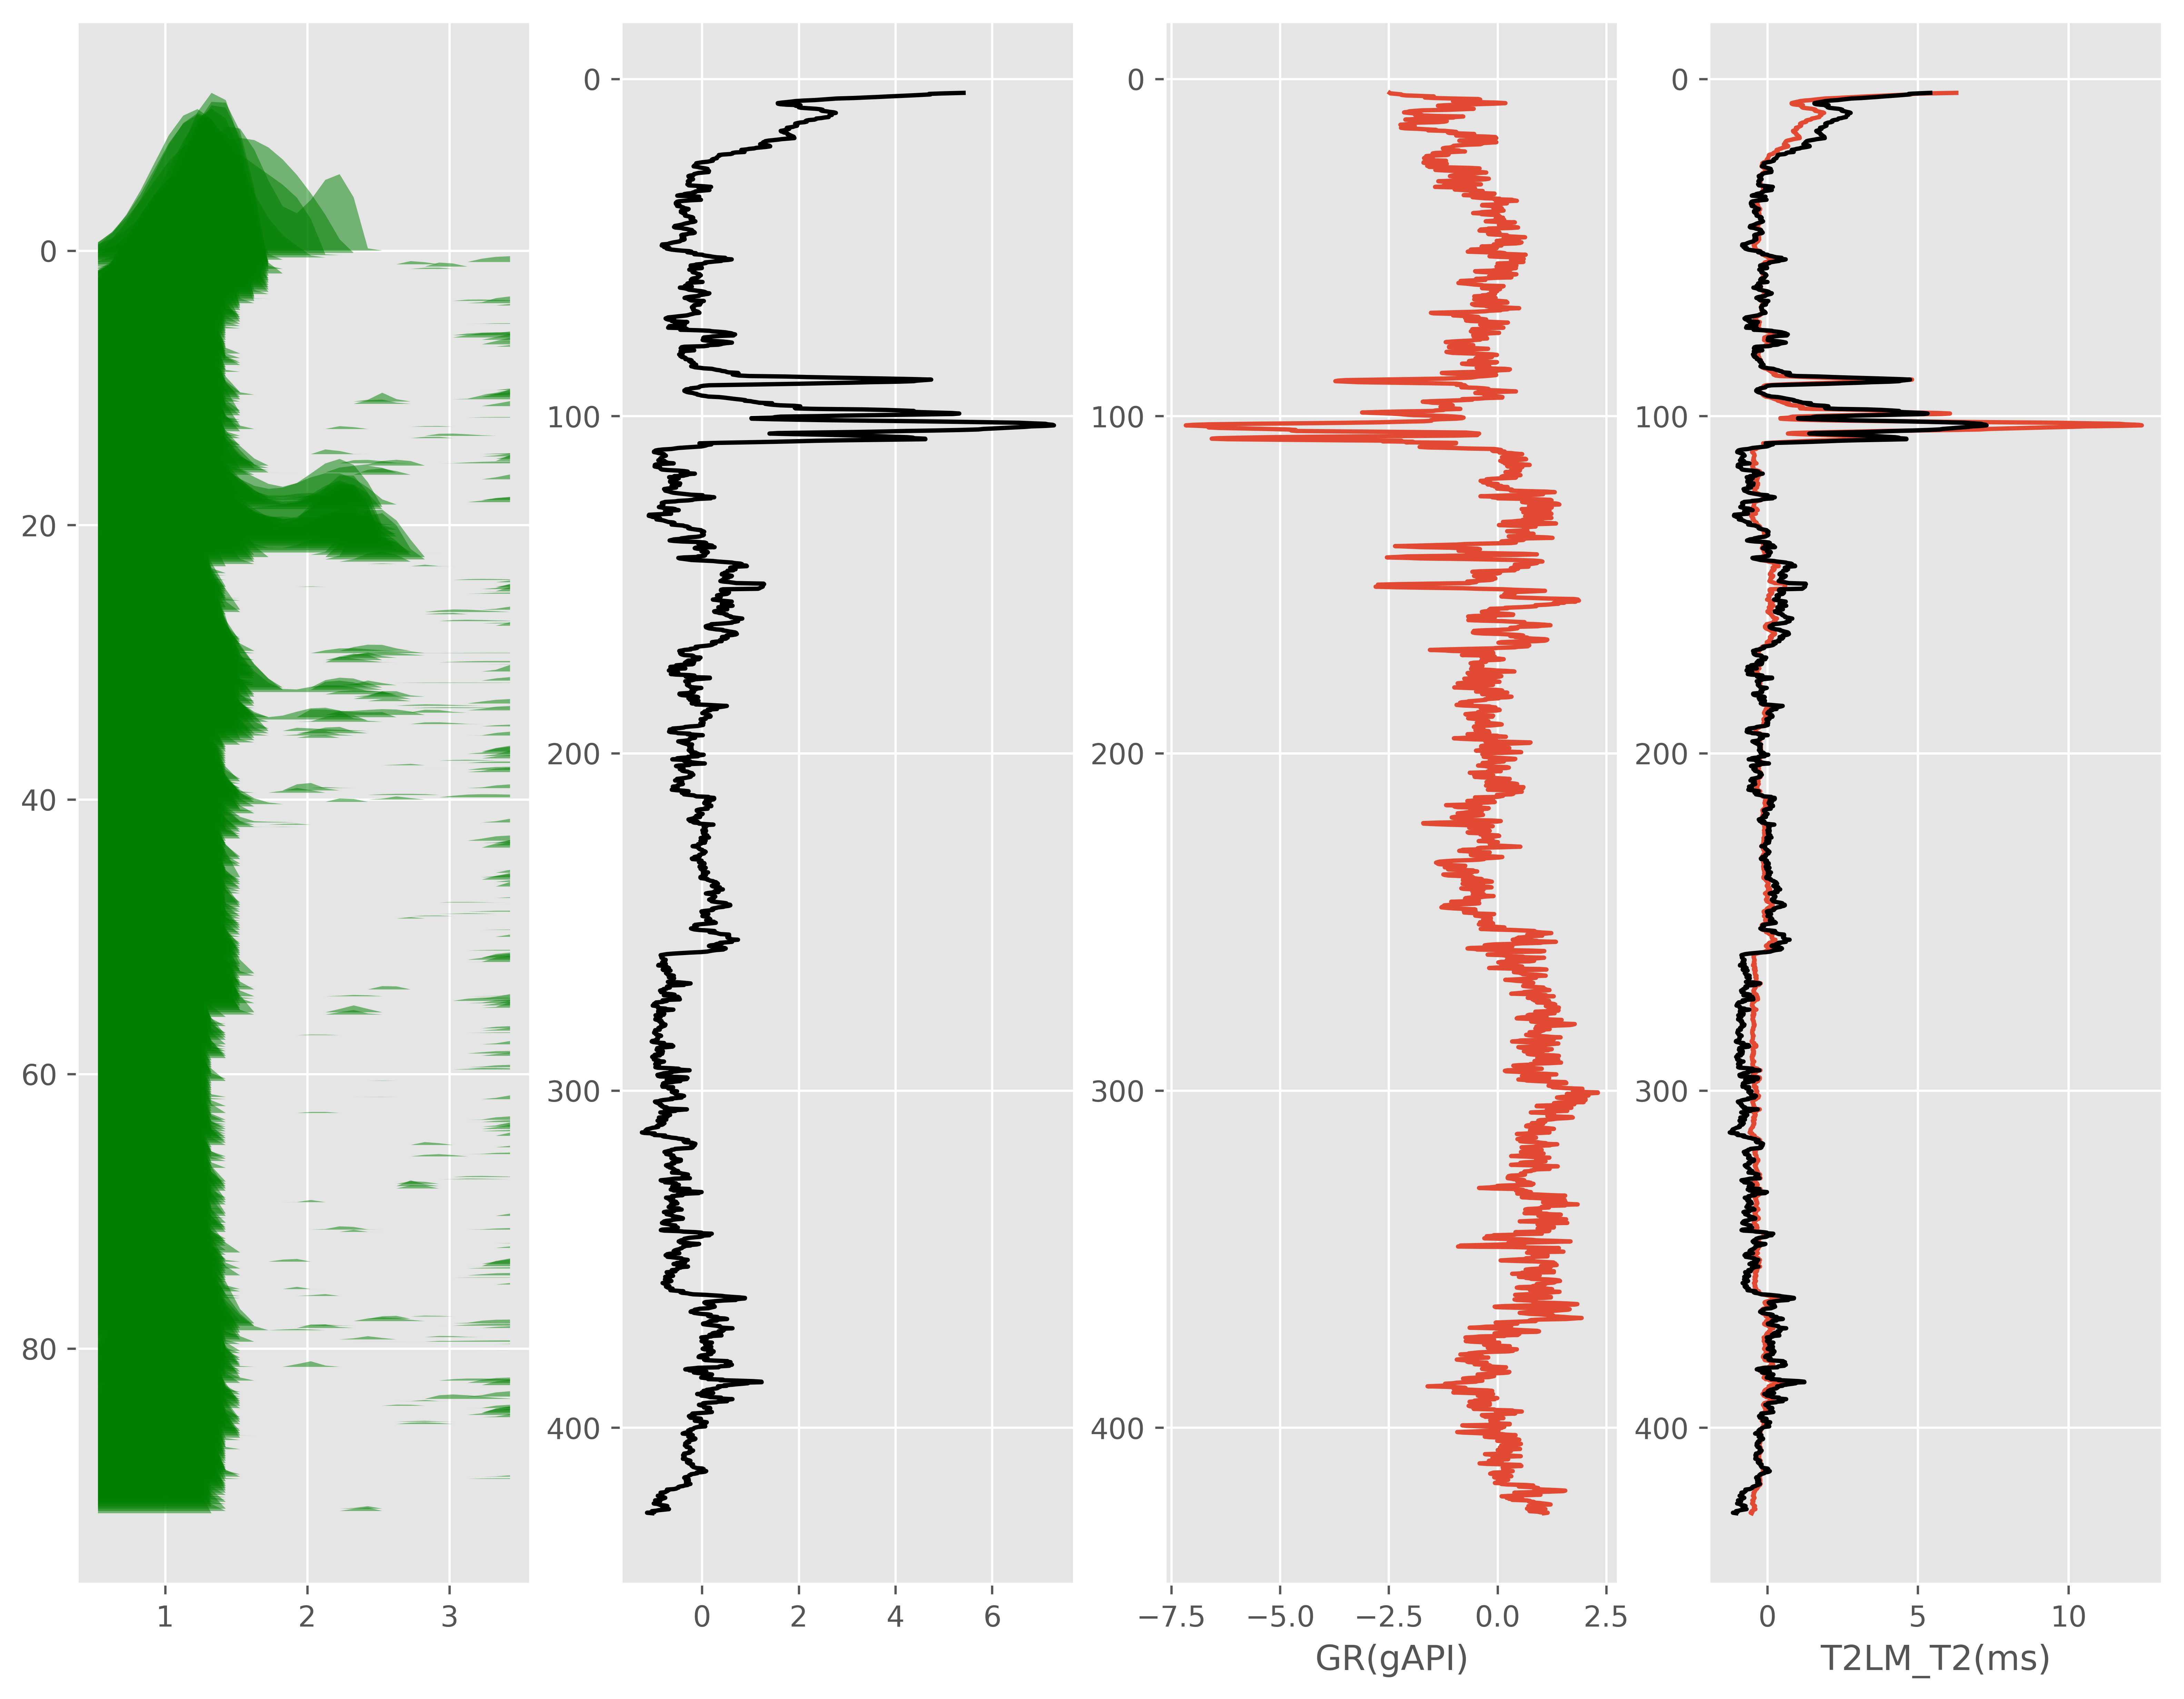

In [23]:
figure = plt.figure(figsize=(4,6))

num_plot = 4
fig, axies = plt.subplots(1,num_plot,figsize=(13,10),dpi=600)
axies[2].plot(df_merge_logs_standard['GR(gAPI)'],df_merge_logs['DEPTH(m)'])
axies[2].invert_yaxis()
axies[2].set_xlabel('GR(gAPI)')

axies[3].plot(df_merge_logs_standard['T2LM_T2(ms)'],df_merge_logs['DEPTH(m)'])
legend_31, = axies[3].plot(df_merge_logs_standard['mean_log10_t2'],df_merge_logs['DEPTH(m)'],'k',label='mean')
axies[3].invert_yaxis()
axies[3].set_xlabel('T2LM_T2(ms)')

legend_mean, = axies[1].plot(df_merge_logs_standard['mean_log10_t2'],df_merge_logs['DEPTH(m)'],'k',label='mean')
#legend_std, = axies[1].plot(df_merge_logs_standard['std_log10_t2'],df_merge_logs['DEPTH(m)'],label='std')
axies[1].invert_yaxis()
#axies[1].legend(handles=[legend_mean,legend_std],loc=4)
#axies[1].set_xlabel('GR(gAPI)')

# figure 3
for i in range(0,len(df_all_logs[4]),5):
    t2_y =np.array(df_all_logs[4].iloc[i,1:]) # the nmr distribution logs
    #t_plot1 = np.array([elem if elem < 0.01 else np.nan for elem in t2_y])
    t_plot2 = np.array([elem if elem >=0.0001 else np.nan for elem in t2_y])
    axies[0].fill_between(log10_x_t2_1d, i/30, -t2_y+i/30, facecolor='green',alpha=0.5)
    #axies[0].plot(log10_x_t2_1d,-t2_y,'r',alpha=0.1)
    #axies[0].plot(log10_x_t2_1d,-t_plot2+i/30,'w',alpha=0.6)
axies[0].invert_yaxis()